HHU Deep Learning in Life Science: Generative Models, Prof. Dr. **Markus Kollmann**, WS 2025-2026

Tutors: **Felix Michels** and **Adaloglou Nikolaos**
## Assignment 2 - Generative Adversarial Networks (GANs)

- **Submission  [link](https://uni-duesseldorf.sciebo.de/s/dfsNtqFGMf7YxZk)**
- **Deadline**: 13/11/2025 (2-week exercise)
- **Note**: `Rename` your file BEFORE submitting!
- If you encounter issues that might apply to other students, please notify others in the group chat.

#### How to submit
- Submit the solved notebook (not a zip) with your full name (`NAME_SURNAME`) plus assingment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for `assignment 1`. If you have more names, please use only the first one for all homeworks.
- Please use the same naming convention `NAME_SURNAME_aX` to faciliate the tutors.
- You are free to modify our code as you see fit.
  
#### Overview:
- This exercise is about implementing and understanding Generative Adversarial Networks based on [this](https://arxiv.org/abs/1406.2661) paper. The tasks where you have to fill code are numbered as `Task XYZ`. 
- Part A involves unconditional training on MNIST images using MLPs.
- Part B involves training a conditional convolutional GAN on CIFAR10.


### Preparation and Data Setup

In [48]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torchvision.datasets as datasets
import torch.utils.data as data
import matplotlib.pyplot as plt
import torch.nn.functional as F


np.random.seed(42)
torch.manual_seed(42)
cuda = torch.cuda.is_available()
print(f"Using GPU: {cuda}")
device = torch.device('cuda') if cuda else torch.device('cpu')
# Hyper-parameters
latent_size = 64
G_hidden_size = 512
D_hidden_size = 64
image_size = 784 
batch_size = 128
sample_dir = './expected_results'
save_dir = './gans'
data_folder = './data'

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Image processing
transform = transforms.Compose([
                transforms.ToTensor()])

# MNIST dataset
train_set = torchvision.datasets.MNIST(root=data_folder,
                                   train=True,
                                   transform=transform,
                                   download=True)

test_set = torchvision.datasets.MNIST(root=data_folder,
                                   train=False,
                                   transform=transform,
                                   download=True)

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                          batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=batch_size, 
                                          shuffle=True)

# input: [bs, 1, 28, 28]
def make_image_grid(images, nrow=8):
    """Helper function for plotting later"""
    images = images.float()  
    grid = torchvision.utils.make_grid(images, nrow)
    grid = grid.permute(1, 2, 0).cpu().numpy()  # from CHW to HWC
    return grid


def sample(n, G, latent_size, label_id=None, condition=False, flatten=True, device="cuda", gen_one_hot=None):
    """Function to generate samples from the generator G
    Inputs:
    - n: number of samples to generate
    - G: generator model
    - latent_size: size of the latent noise vector
    - label_id: specific label to generate (int) or None for random labels
    - condition: boolean flag indicating whether to condition on labels
    - device: device to perform computations on
    - gen_one_hot: function to generate one-hot encoded labels
    Returns:
    - samples: generated samples from the generator G
    """
    z = torch.randn(n, latent_size, 1, 1).to(device)
    if flatten:
        z = z.view(n, latent_size)
    
    if condition:
        # gen_one_hot will be implemented in part B
        label_ids = gen_one_hot(n, label_id) 
        if label_ids is not None:
            label_ids = label_ids.to(device)
        samples = G(z, label_ids)
    else:
        samples = G(z)
    if flatten:
        samples = samples.view(n, 1, 28, 28)
    return samples

Using GPU: True


## Task A1. Implement GAN Architecture

In this task, you will implement a basic NLP-based GAN architecture with a Generator and Discriminator using fully connected layers. Here are the specifications:

### Important Notes:
- Real images are in the range [0, 1]
- The Generator should output images in the same range [0, 1] using a proper activation
- The Discriminator should output raw logits (no sigmoid) as we'll use BCEWithLogitsLoss later

### Expected Architecture:
```
Generator(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): Activation
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Activation
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Activation
  )

Discriminator(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Activation
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Activation
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
```



In [49]:
class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, 1)
        )
        
    def forward(self, x):
        return self.net(x)

    
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, image_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

G = Generator(latent_size, image_size, G_hidden_size)
D = Discriminator(image_size, D_hidden_size)

## Task A2. Implement the training of the generator

In this task, you'll implement the function to train the generator. Follow these steps carefully:

1. Sample a minibatch of random noise vectors `z`
2. Generate fake images using the generator: `G(z)`
3. Pass the fake images through the discriminator to get predictions
4. Calculate the generator's loss based on the discriminator's predictions
5. Update the generator parameters using backpropagation


#### Additional notes
- Calculate the part of the objective, that involves $G$. For what we call original GAN objective (`orig_obj=True`), minimize `-log(D(G(z)))` (equivalent to maximizing `log(D(G(z)))`). For `orig_obj=False`, implement Eq. 1 https://arxiv.org/pdf/1406.2661: minimize log(1-D(G(z)))
- Keep in mind that the backpropagation should not create gradients for D. 
- `Tip`: Use `fake_imgs = G(z, labels) if labels is not None else G(z)` to support conditional and unconditional imge generation. In this part we will train an unconditional GAN.
- `Tip`: There is a handy loss function, called 'BCEWithLogitsLoss' that combines a 'Sigmoid' layer and 'BCELoss' in a single class. This has numerical advantages, because the log and exp cancel. Hence, we don't need a sigmoid layer at the end of D, since it's included in the loss function. 

The image below provides some info you may find useful:

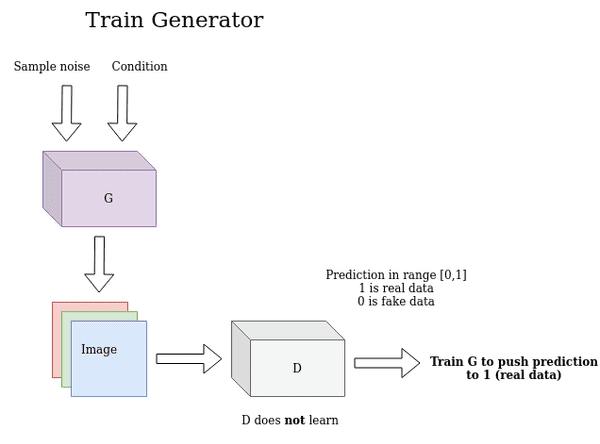



In [114]:
def train_generator(G, D, g_optimizer, z, criterion=nn.BCEWithLogitsLoss(), labels=None, orig_obj=True):
    """
    Train the generator G.
    Inputs:
    - G: Generator model
    - D: Discriminator model
    - g_optimizer: Optimizer for the generator
    - z: Input noise tensor for the generator
    - criterion: Loss function
    - labels: Optional labels for conditional GANs
    - orig_obj: Boolean flag indicating whether to use:
        -  True: maximize log(D(G(z)))
        -  False: GAN objective (Eq. 1 https://arxiv.org/pdf/1406.2661 ): minimize log(1-D(G(z)))
    Returns:
    - loss: Computed loss for the generator
    - fake_imgs: Generated fake images from the generator
    - pred_fake: Discriminator predictions on the generated fake images
    """
    ### START CODE HERE ###
    g_optimizer.zero_grad()
    if labels is not None:
        fake_imgs = G(z, labels)
    else:
        fake_imgs = G(z)
    pred_fake = D(fake_imgs)
    if orig_obj:
        # Generator tries to fool D that fakes are real (use 1.0, not 0.9!)
        # Only D uses label smoothing (0.9), not G!
        real_labels = torch.ones(pred_fake.size(), device=pred_fake.device)
        loss = criterion(pred_fake, real_labels)
    else:
        fake_labels = torch.zeros(pred_fake.size(), device=pred_fake.device)
        loss = criterion(pred_fake, fake_labels)
    loss.backward()
    g_optimizer.step()

    ### END CODE HERE ###
    return loss, fake_imgs, pred_fake

## Task A3. Implement the training of the discriminator (D)

In this task, you'll implement the discriminator training function following these steps:


1. Obtain a minibatch of real images and their corresponding labels. Process real images:
   - Pass real images through the discriminator
   - Calculate the first part of the loss: $\mathbb{E}_{x \sim p_{data}(x)} [\log D(x)]$ (real images should be classified as real)
2. Process fake images:
   - Get fake images from the generator
   - **Detach the fake images** from the computational graph to prevent generator updates
   - Pass fake images through the discriminator
   - Calculate the second part of the loss: $\mathbb{E}_{x \sim p_{data}(x)} [\log (1 - D(G(z))]$, via BinaryCrossEntropy loss. (fake images should be classified as fake)
3. Calculate the total discriminator loss by adding the two loss terms from above.

This is only a guideline. Implement the function based on your understanding.


**Important:**
- Use `torch.ones` for real image targets and `torch.zeros` for fake image targets

The image below provides some info you may find useful:

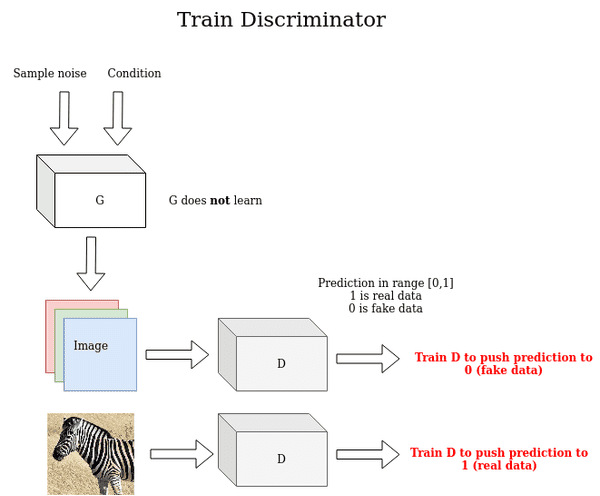

In [115]:
def train_discriminator(D, d_optimizer, real_imgs, fake_imgs, criterion=nn.BCEWithLogitsLoss(), device='cuda'):
    """
    Train the discriminator D.
    Inputs:
    - D: Discriminator model
    - d_optimizer: Optimizer for the discriminator
    - real_imgs: Batch of real images
    - fake_imgs: Batch of fake images generated by the generator
    - criterion: Loss function i.e. criterion = nn.BCEWithLogitsLoss()
    Returns:
    - loss_D: Computed loss for the discriminator
    - pred_real: Discriminator predictions on the real images
    """
    ### START CODE HERE ###
    d_optimizer.zero_grad()

    # Predictions on real images
    pred_real = D(real_imgs)
    # Use random values between 0.8 and 1.0 for more robust training
    real_labels = torch.empty_like(pred_real).uniform_(0.8, 1.0).to(device)
    loss_real = criterion(pred_real, real_labels)

    # Predictions on fake images
    pred_fake = D(fake_imgs.detach())
    fake_labels = torch.empty_like(pred_fake).uniform_(0.0, 0.2).to(device)
    loss_fake = criterion(pred_fake, fake_labels)
    
    loss_D = loss_real + loss_fake
    loss_D.backward()
    d_optimizer.step()
    ### END CODE HERE ###
    return loss_D, pred_real

## Task A4. Implement the training logic of GANs

Goal: Your implementation should handle all the logic to train a GAN for unconditional image generation.

In this task, you will create the main training loop that coordinates the generator and discriminator training. This function should handle the complete training process for a GAN model focused on unconditional image generation.

### Implementation Requirements:
1. Process each batch of training data in every epoch
2. For each batch:
   - Train the generator using your `train_generator` function
   - Train the discriminator using your `train_discriminator` function
   - Track metrics in the provided `logs` dictionary

### Function Arguments:
- `epochs`: Number of training epochs
- `G`: Generator model
- `D`: Discriminator model
- `train_loader`: DataLoader with training data
- `latent_size`: Size of the latent noise vector
- `g_optimizer`: Generator optimizer
- `d_optimizer`: Discriminator optimizer
- `logs`: Dictionary to store training statistics
- Additional parameters for flexibility

### Training Statistics:
Your implementation must record the following metrics in the `logs` dictionary:
- `g_loss_hist`: Generator loss after each iteration
- `d_loss_hist`: Discriminator loss after each iteration
- `prob_fake_hist`: Discriminator's probability outputs for fake images (apply sigmoid to convert logits to probabilities)
- `prob_real_hist`: Discriminator's probability outputs for real images (apply sigmoid to convert logits to probabilities)

### Important
- Make sure your implementation can handle both flattened images (MNIST) and image tensors (CIFAR-10) by checking the `flatten` parameter.
- The condition parameter controls whether we train conditionally or unconditionally, which is needed for sampling.
- `gen_one_hot` will be implemented in part b for conditional generation.

In [122]:
from tqdm import tqdm



def train(epochs, G, D, train_loader, latent_size, g_optimizer, d_optimizer, logs, 
          orig_obj=True, condition=False,
          flatten=True, plot=True, gen_one_hot=None,
          dset_name='mnist', device='cuda'): 
    G.to(device); D.to(device)

    def set_requires_grad(model, requires_grad):
        for param in model.parameters():
            param.requires_grad = requires_grad
    
    D.train(); G.train()
    
    for epoch in tqdm(range(epochs)):
        for i, (images, labels) in enumerate(train_loader):
            # labels are not used in part A.
            labels = labels.to(device) if condition else None 
            ### START CODE HERE ###

            # prepare real images
            if flatten:
                c, h, w = images.size(1), images.size(2), images.size(3)
                real_images = images.view(images.size(0), -1).to(device)
            else:
                real_images = images.to(device)

            z = torch.randn(images.size(0), latent_size, device=device)
            if not flatten:
                z = z.unsqueeze(2).unsqueeze(3)  # reshape to [bs, latent_size, 1, 1]

            if condition and labels is not None:
                # For conditional GAN, use random labels (as we want to generate all classes)
                labels_train = gen_one_hot(images.size(0), None).to(device)
            else:
                labels_train = labels

            # Train Discriminator (train it twice if it's too weak)
            D.train(); set_requires_grad(D, True)
            with torch.no_grad():
                if labels is not None:
                    fake_images = G(z, labels_train)
                else:
                    fake_images = G(z)
            d_loss, pred_real = train_discriminator(D, d_optimizer, real_images, fake_images, device=device)
            d_loss_scalar = d_loss.item()

            # Train Generator
            D.eval(); set_requires_grad(D, False)
            g_loss, fake_images, pred_fake = train_generator(G, D, g_optimizer, z, labels=labels_train, orig_obj=orig_obj)
            g_loss_scalar = g_loss.item()

    
            ### END CODE HERE ###
            
            # =================================================================== #
            #                          Update Statistics                          #
            # =================================================================== #
            # add sigmoid for ploting the probabilities
            pred_real = torch.sigmoid(pred_real).mean().cpu().detach()
            pred_fake = torch.sigmoid(pred_fake).mean().cpu().detach()

            logs["d_loss_hist"].append(d_loss_scalar)
            logs["g_loss_hist"].append(g_loss_scalar)

            logs["prob_fake_hist"].append(pred_fake)
            logs["prob_real_hist"].append(pred_real)
        # update tqdm with the info
        if (epoch+1) % 10 == 0:
            tqdm.write(f"Loss_D: {d_loss_scalar:.3f}. Loss_G: {g_loss_scalar:.3f}. D(x): {pred_real:.3f}. D(G(z)): {pred_fake:.3f}.")
            
        # Plot samples
        if (epoch+1) % 20 == 0 and plot:
            num_samples = 16
            samples = sample(num_samples, G, latent_size=latent_size, label_id=None, condition=condition,
                             flatten=flatten, gen_one_hot=gen_one_hot, device=device)
            if flatten:
                samples = samples.view(num_samples, c, h, w)
                plt.figure(figsize=(8,8))
                plt.title("Test Samples")
                plt.imshow(make_image_grid(samples, nrow=8))
            else:
                # scale intensities from [-1, 1] --> [0, 1]
                samples = (samples + 1)/2
                plt.figure(figsize=(12,12))
                plt.title("Test Samples")
                plt.imshow(make_image_grid(samples, nrow=4))
            plt.axis("off")
            plt.show()

        # Save model at checkpoints
        if (epoch+1) % 50 == 0:
            torch.save(G.state_dict(), os.path.join(save_dir, f'G_ep{epoch}_{dset_name}.ckpt'))
            torch.save(D.state_dict(), os.path.join(save_dir, f'D_ep{epoch}_{dset_name}.ckpt'))
    # Save the model checkpoints
    torch.save(G.state_dict(), os.path.join(save_dir, f'G_last_{dset_name}.ckpt'))
    torch.save(D.state_dict(), os.path.join(save_dir, f'D_last_{dset_name}.ckpt'))
    return logs

## Task A5. Implement and run training

In this task, you will initialize your models and run the training process for the unconditional GAN on MNIST.

### Steps to Complete:
1. Initialize the Generator and Discriminator models with the appropriate parameters
2. Call the `train` function with the proper parameters to train your GAN
3. Train with `orig_obj=True`.

### Expected Code:
- Call the training function with the required parameters
- Set `flatten=True` since we're working with MNIST (will be flattened to 784-dim vectors)

After training, your GAN should be able to generate recognizable digit images from random noise vectors.

  5%|▌         | 10/200 [00:37<12:00,  3.79s/it]

Loss_D: 0.891. Loss_G: 1.742. D(x): 0.635. D(G(z)): 0.158.


 10%|▉         | 19/200 [01:15<11:21,  3.76s/it]

Loss_D: 1.021. Loss_G: 1.410. D(x): 0.661. D(G(z)): 0.242.


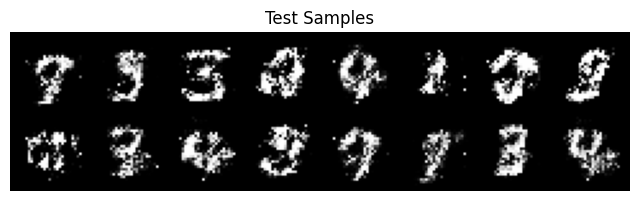

 15%|█▌        | 30/200 [01:54<10:54,  3.85s/it]

Loss_D: 1.294. Loss_G: 0.982. D(x): 0.505. D(G(z)): 0.374.


 20%|█▉        | 39/200 [02:31<10:10,  3.79s/it]

Loss_D: 1.314. Loss_G: 0.863. D(x): 0.473. D(G(z)): 0.416.


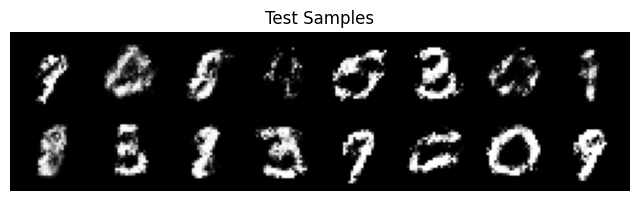

 25%|██▌       | 50/200 [03:10<09:33,  3.82s/it]

Loss_D: 1.332. Loss_G: 0.862. D(x): 0.475. D(G(z)): 0.414.


 30%|██▉       | 59/200 [03:48<08:58,  3.82s/it]

Loss_D: 1.326. Loss_G: 0.868. D(x): 0.489. D(G(z)): 0.412.


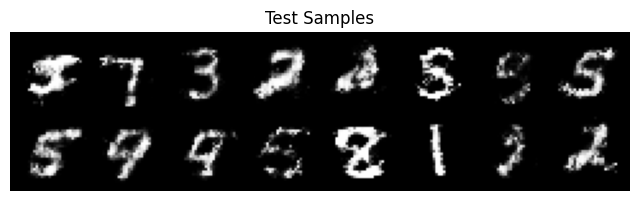

 35%|███▌      | 70/200 [04:26<08:14,  3.80s/it]

Loss_D: 1.365. Loss_G: 0.875. D(x): 0.452. D(G(z)): 0.409.


 40%|███▉      | 79/200 [05:04<07:37,  3.78s/it]

Loss_D: 1.352. Loss_G: 0.910. D(x): 0.442. D(G(z)): 0.392.


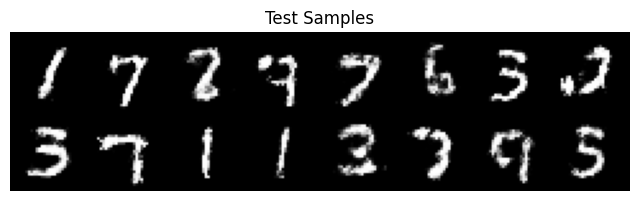

 45%|████▌     | 90/200 [05:42<06:54,  3.77s/it]

Loss_D: 1.296. Loss_G: 0.914. D(x): 0.478. D(G(z)): 0.391.


 50%|████▉     | 99/200 [06:19<06:21,  3.78s/it]

Loss_D: 1.306. Loss_G: 0.873. D(x): 0.489. D(G(z)): 0.412.


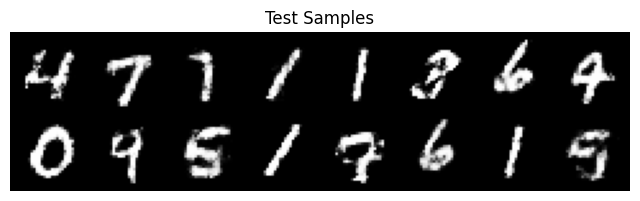

 55%|█████▌    | 110/200 [06:57<05:40,  3.79s/it]

Loss_D: 1.289. Loss_G: 0.891. D(x): 0.485. D(G(z)): 0.402.


 60%|█████▉    | 119/200 [07:35<05:07,  3.79s/it]

Loss_D: 1.307. Loss_G: 0.877. D(x): 0.467. D(G(z)): 0.412.


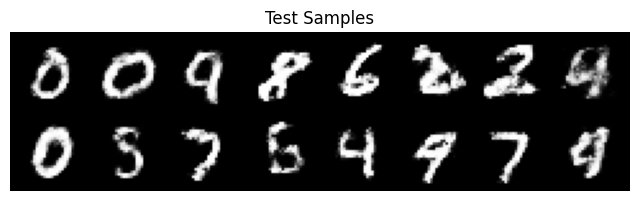

 65%|██████▌   | 130/200 [08:13<04:24,  3.78s/it]

Loss_D: 1.250. Loss_G: 0.969. D(x): 0.483. D(G(z)): 0.374.


 70%|██████▉   | 139/200 [08:51<03:51,  3.80s/it]

Loss_D: 1.268. Loss_G: 0.871. D(x): 0.515. D(G(z)): 0.413.


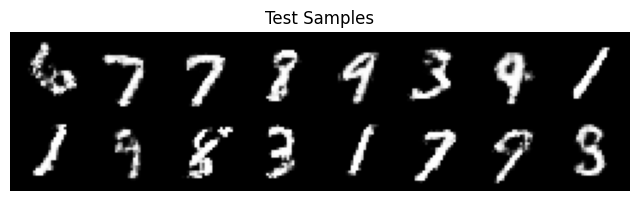

 75%|███████▌  | 150/200 [09:29<03:09,  3.80s/it]

Loss_D: 1.308. Loss_G: 0.911. D(x): 0.527. D(G(z)): 0.403.


 80%|███████▉  | 159/200 [10:07<02:35,  3.79s/it]

Loss_D: 1.289. Loss_G: 0.956. D(x): 0.502. D(G(z)): 0.379.


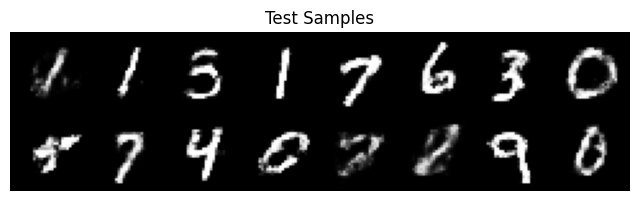

 85%|████████▌ | 170/200 [10:45<01:53,  3.78s/it]

Loss_D: 1.223. Loss_G: 1.026. D(x): 0.512. D(G(z)): 0.355.


 90%|████████▉ | 179/200 [11:23<01:19,  3.80s/it]

Loss_D: 1.274. Loss_G: 0.945. D(x): 0.489. D(G(z)): 0.387.


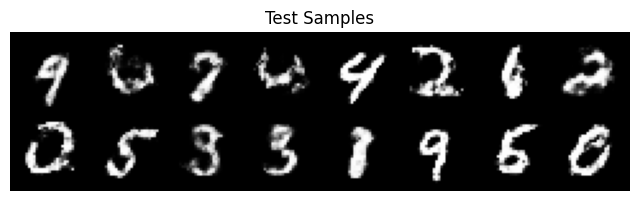

 95%|█████████▌| 190/200 [12:01<00:37,  3.80s/it]

Loss_D: 1.295. Loss_G: 0.951. D(x): 0.489. D(G(z)): 0.385.


100%|█████████▉| 199/200 [12:39<00:03,  3.79s/it]

Loss_D: 1.277. Loss_G: 0.960. D(x): 0.513. D(G(z)): 0.378.


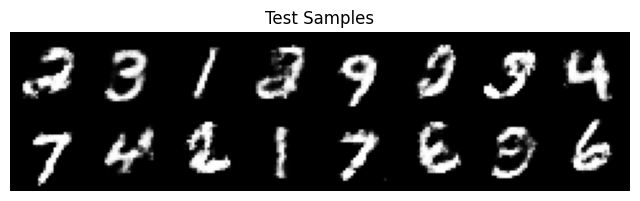

100%|██████████| 200/200 [12:39<00:00,  3.80s/it]


In [72]:
logs_mnist_orig = {"d_loss_hist": [],
        "g_loss_hist": [],
        "prob_real_hist": [],
        "prob_fake_hist": []}
epochs = 200
dset_name = 'mnist_orig'
orig_obj=True
### START CODE HERE ###

D = Discriminator(image_size, D_hidden_size).to(device)
G = Generator(latent_size, image_size, G_hidden_size).to(device)

g_optimizer = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
logs_mnist_orig = train(epochs, G, D, train_loader, latent_size, g_optimizer, d_optimizer,
                        logs_mnist_orig, orig_obj=orig_obj, condition=False,
                        flatten=True, plot=True, dset_name=dset_name, device=device)
### END CODE HERE ###

## Evaluation
Provided. No code need to be filled here.

/tmp/ipykernel_3733901/4044056298.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load(os.path.join(save_dir, f'G_last_{dset_name}.ckpt')))


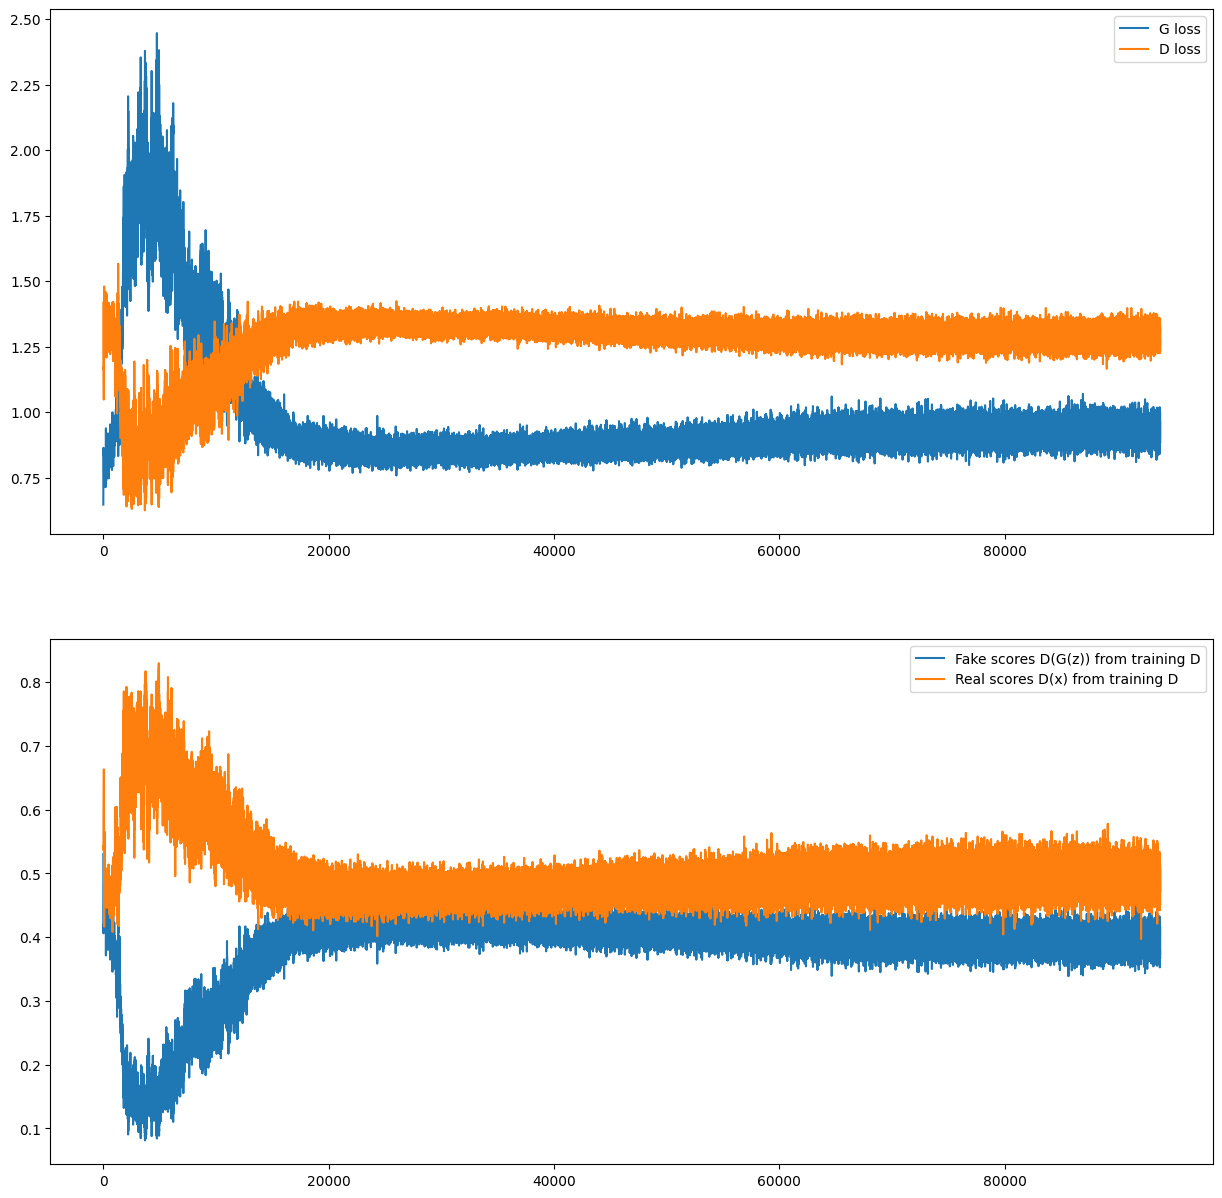

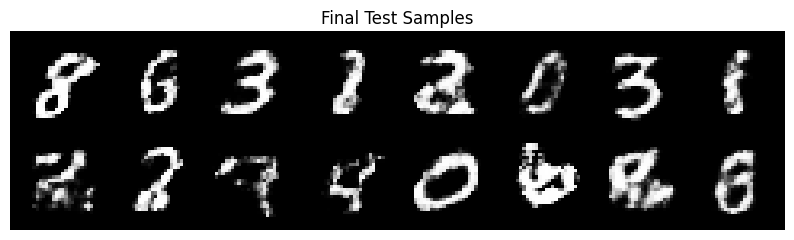

In [73]:
#for logs, name in zip([logs_mnist, logs_mnist_orig], ['mod_obj', 'orig_obj']):
dset_name = 'mnist_orig'
for logs, name in zip([logs_mnist_orig], ['orig_obj']):
    fig, axes = plt.subplots(figsize=(15,15), ncols=1, nrows=2)
    plt.subplot(2,1,1)
    plt.plot(logs["g_loss_hist"], label='G loss')
    plt.plot(logs["d_loss_hist"], label='D loss')    
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(logs["prob_fake_hist"], label='Fake scores D(G(z)) from training D')
    plt.plot(logs["prob_real_hist"], label='Real scores D(x) from training D')
    plt.legend()
    plt.savefig(f'{sample_dir}/part_a_losses_and_scores_mnist_{name}.png', bbox_inches='tight')

    # load generator
    G = Generator(latent_size, image_size, G_hidden_size)
    G.load_state_dict(torch.load(os.path.join(save_dir, f'G_last_{dset_name}.ckpt')))
    G = G.to(device)

    samples = sample(16, G, latent_size=latent_size, condition=False, flatten=True)
    plt.figure(figsize=(10,10))
    plt.title("Final Test Samples")
    plt.imshow(make_image_grid(samples, nrow=8))
    plt.axis("off")
    plt.savefig(f'{sample_dir}/part_a_mnist_test_samples_{name}.png', bbox_inches='tight')
    plt.show()

## Part B. Implement and train a conditional DCGAN on CIFAR10

This part is about implementing and understanding the [DCGAN](https://arxiv.org/abs/1511.06434v2) model and incorporate the class label information.

## Task B1. Prepare CIFAR10 data loading

In this task, you'll set up the data pipeline for the CIFAR10 dataset to train a DCGAN model. 

### Implementation Requirements:
1. Load the CIFAR10 dataset from `torchvision.datasets`
2. Create a function to convert scalar labels to one-hot encoded vectors (for conditional GAN)
3. Apply the following transformations to the images:
   - Resize images to 64x64 (standard size for DCGAN architecture)
   - Convert to tensors
   - Normalize pixel values to range [-1, 1] (unlike MNIST which was [0, 1])
4. Ruturns: DataLoader


In [ ]:
# Image processing
transform = transforms.Compose([
                transforms.ToTensor()])

# MNIST dataset
train_set = torchvision.datasets.MNIST(root=data_folder,
                                   train=True,
                                   transform=transform,
                                   download=True)

test_set = torchvision.datasets.MNIST(root=data_folder,
                                   train=False,
                                   transform=transform,
                                   download=True)

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                          batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [117]:
from torchvision.transforms.transforms import Resize

# Hyper-parameters
latent_size = 64
G_hidden_size = 512
D_hidden_size = 64
image_size = 784 
batch_size = 128
num_classes = 10

def get_data_loader(batch_size):
    ### START CODE HERE ###

    

    transform = transforms.Compose([
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalize to [-1, 1]
    
    to_onehot = lambda y: F.one_hot(torch.tensor(y), num_classes=num_classes).float()

    train_set = torchvision.datasets.CIFAR10(root=data_folder,
                                       train=True,
                                       transform=transform,
                                       target_transform=to_onehot,
                                       download=True)
    test_set = torchvision.datasets.CIFAR10(root=data_folder,
                                      train=False,
                                      transform=transform,
                                      target_transform=to_onehot,
                                      download=True)
    dataloader = torch.utils.data.DataLoader(dataset=train_set,
                                          batch_size=batch_size, 
                                          shuffle=True)
    ### END CODE HERE ###
    return dataloader

# Given for testing
imgs, labels = next(iter(get_data_loader(batch_size=2)))
print(imgs.shape)
print(labels.shape)
print(labels)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
torch.Size([2, 3, 64, 64])
torch.Size([2, 10])
tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
torch.Size([2, 3, 64, 64])
torch.Size([2, 10])
tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


## Task B2. Implement an convolutional generator using transpose convolutions.



In this task, you'll implement the DCGAN generator architecture with support for conditional generation. The generator will transform random noise (and optionally class labels) into synthetic images. The Generator architecture should have a boolean parameter that controls whether there is a condition (label one hot vector or not).

### Architecture Requirements:
- Build a generator using transpose convolutions that upsamples from a latent vector to a 64x64x3 image
- Include a conditional option to incorporate class label information (one-hot encoded)
- If conditional is True, embed the label using a linear layer and concatenate with the noise vector
- Use a modular approach with `g_base_channels` to control network capacity

### Implementation Details:
- Start with a latent vector of shape (batch_size, z_size, 1, 1)
- If **conditional=True**, add a linear layer to embed the label and concatenate with the latent vector!
- Apply 5 transposed convolution layers with batch normalization and ReLU activations
- Use a Tanh activation in the final layer to output values in range [-1, 1]

### Expected Architecture:

In general it's a good idea to make the implementation modular. In this case for example both models have `base_channels = 64` and go up to `base_channels*8= 512`. This will make it able for you to scale up and down G and D with a single parameter. It is totally optional though.


```
base_channels = 64
max_channels = base_channels*8 
Generator(
  Linear(in_features=10, out_features=128, bias=True)
  Sequential(
    (0): ConvTranspose2d(z_size, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d
    (2): Activation function
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d
    (5): Activation function
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d
    (8): Activation function
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d
    (11): Activation function
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Activation function
  )
)
```

In [118]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("Linear") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class DcganGenerator(nn.Module):
    def __init__(self, out_channels=3, z_size=100, g_base_channels=64, condition=True,
                        num_labels=10, label_latent_dim=128):
        """
        out_channels: image channels to generate
        z_size: noise vector size
        g_base_channels: input channels of G of the last transp. Conv layer.
                          Controls network complexity
        condition: whether to include labels
        num_labels: number of classes
        label_latent_dim: latent dimension of the label embedding
        """
        super(DcganGenerator, self).__init__()
        ### START CODE HERE ###
        max_channels = g_base_channels * 8
        self.condition = condition
        self.label_emb = nn.Linear(num_labels, label_latent_dim) if condition else None
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_size + (label_latent_dim if condition else 0), max_channels, 4, 1, 0, bias=False),
            nn.BatchNorm2d(max_channels),
            nn.ReLU(True),
            nn.ConvTranspose2d(max_channels, g_base_channels * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_base_channels * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(g_base_channels * 4, g_base_channels * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_base_channels * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(g_base_channels * 2, g_base_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_base_channels),
            nn.ReLU(True),
            nn.ConvTranspose2d(g_base_channels, out_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        ### END CODE HERE ###
        
    def forward(self, z, label=None):
        ### START CODE HERE ###
        if self.condition and label is not None:
            label_embedding = self.label_emb(label)
            label_embedding = label_embedding.unsqueeze(2).unsqueeze(3)  # reshape to [bs, label_latent_dim, 1, 1]
            z = torch.cat([z, label_embedding], dim=1)  # concatenate along channel dimension
        out = self.net(z)
        ### END CODE HERE ###
        return out

G = DcganGenerator(z_size=100, g_base_channels=64, condition=True,
    num_labels=10, label_latent_dim=64)
G.apply(weights_init)
z = torch.rand(2,100,1,1)
label = torch.rand(2,10)
img = G(z,label)
assert list(img.shape) == [2, 3, 64, 64]
print("Passed the assertion statement!")

Passed the assertion statement!


## Task B3. Implement the convolutional discriminator

In this task, you'll implement the DCGAN discriminator architecture to classify images as real or fake. 

### Architecture Requirements:
- Create a convolutional discriminator that takes 64x64x3 images as input
- Use strided convolutions to downsample the input image to a single prediction value
- Include batch normalization and LeakyReLU activations (with negative_slope=0.2)
- Return raw logits (not sigmoid-activated) as the output

### Implementation Details:
- Start with an input image of shape (batch_size, 3, 64, 64)
- Apply 5 convolution layers with increasing channel depth (from base_channels to 8*base_channels)
- Use LeakyReLU with negative_slope=0.2 as activation function
- Use batch normalization between convolution layers (except after the first layer)
- Final output should be a tensor of shape (batch_size, 1)

### Expected Architecture:

Here we use `LeakyReLU` instead of `ReLU`. Your network should be looking like this 

```
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)
```



After implementation, test your discriminator with sample outputs from your generator to ensure the shapes are compatible and match the expected output format.

In [119]:
class DcganDiscriminator(nn.Module):
    def __init__(self, nc=3, d_base_channels=64):
        """
        nc: number of input channels
        d_base_channels: out channels of the first conv layer. 
                          Ccontrols network complexity
        """
        super(DcganDiscriminator, self).__init__()
        ndf = d_base_channels
        self.main = nn.Sequential(
            nn.Conv2d(nc, d_base_channels, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        bs = x.shape[0]
        y = self.main(x)
        return y.reshape(bs, 1)

D = DcganDiscriminator()
D.apply(weights_init)
G = DcganGenerator(z_size=100, g_base_channels=64, condition=False)
img = G(z)
assert list(img.shape) == [2, 3, 64, 64]
out = D(img)
print(out.shape)
assert list(out.shape) == [2, 1]
print("Passed the assertion statement!")

torch.Size([2, 1])
Passed the assertion statement!


In [120]:
def make_image_grid(images, nrow=8):
    """Helper function for plotting later"""
    images = images.float()  
    grid = torchvision.utils.make_grid(images, nrow)
    grid = grid.permute(1, 2, 0).cpu().numpy()  # from CHW to HWC
    return grid

def gen_one_hot(n, label_id=None):
    """Function to generate one-hot encoded labels
    Inputs:
    - n: number of labels to generate
    - label_id: specific label to generate (int) or None for random labels
    Returns:
    - label_ids: one-hot encoded labels tensor of shape (n, 10)
    """
    ### START CODE HERE ###
    num_classes = 10
    if label_id is not None:
        label_ids = torch.zeros(n, num_classes)
        label_ids[:, label_id] = 1.0
    else:
        random_labels = torch.randint(0, num_classes, (n,))
        label_ids = torch.zeros(n, num_classes)
        label_ids[torch.arange(n), random_labels] = 1.0
    ### END CODE HERE ###
    return label_ids

## Task B4. Train the DCGAN on CIFAR10 for conditional image synthesis

In this final task, you'll set up and run the training process for the conditional DCGAN on the CIFAR10 dataset.

### Training Tips:
- Set `flatten=False` since we're working with convolutional architectures
- Make sure to pass the `gen_one_hot` function to handle label generation

After training, your conditional DCGAN should generate images corresponding to the specified CIFAR10 classes.

In [ ]:
logs_cifar = {"d_loss_hist": [],
        "g_loss_hist": [],
        "prob_real_hist": [],
        "prob_fake_hist": []}

### START CODE HERE ###
data_loader = get_data_loader(batch_size)
z_size = 100
G = DcganGenerator(z_size=z_size, g_base_channels=64, condition=True,
    num_labels=10, label_latent_dim=64).to(device)
D = DcganDiscriminator(nc=3, d_base_channels=64).to(device)

# CRITICAL: Apply weight initialization!
G.apply(weights_init)
D.apply(weights_init)

condition = True
optG = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optD = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
### END CODE HERE ###

logs_cifar = train(epochs, G, D, data_loader, z_size, optG, optD, 
        logs_cifar, orig_obj=True, condition=condition, 
        flatten=False, device='cuda',
        gen_one_hot=gen_one_hot,
        dset_name='cifar10')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

## Evaluation

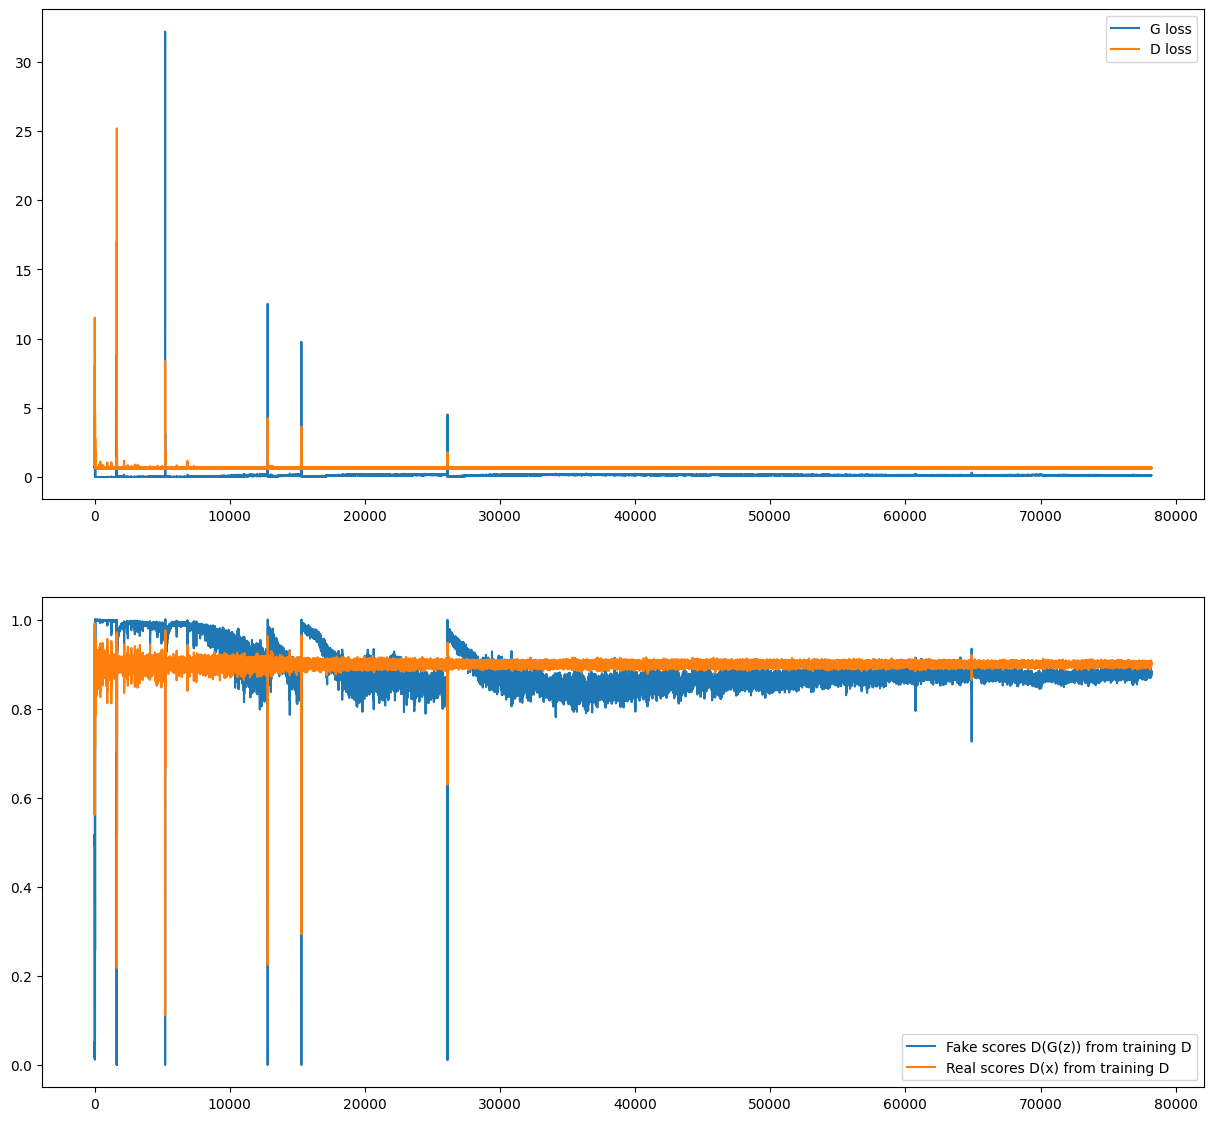

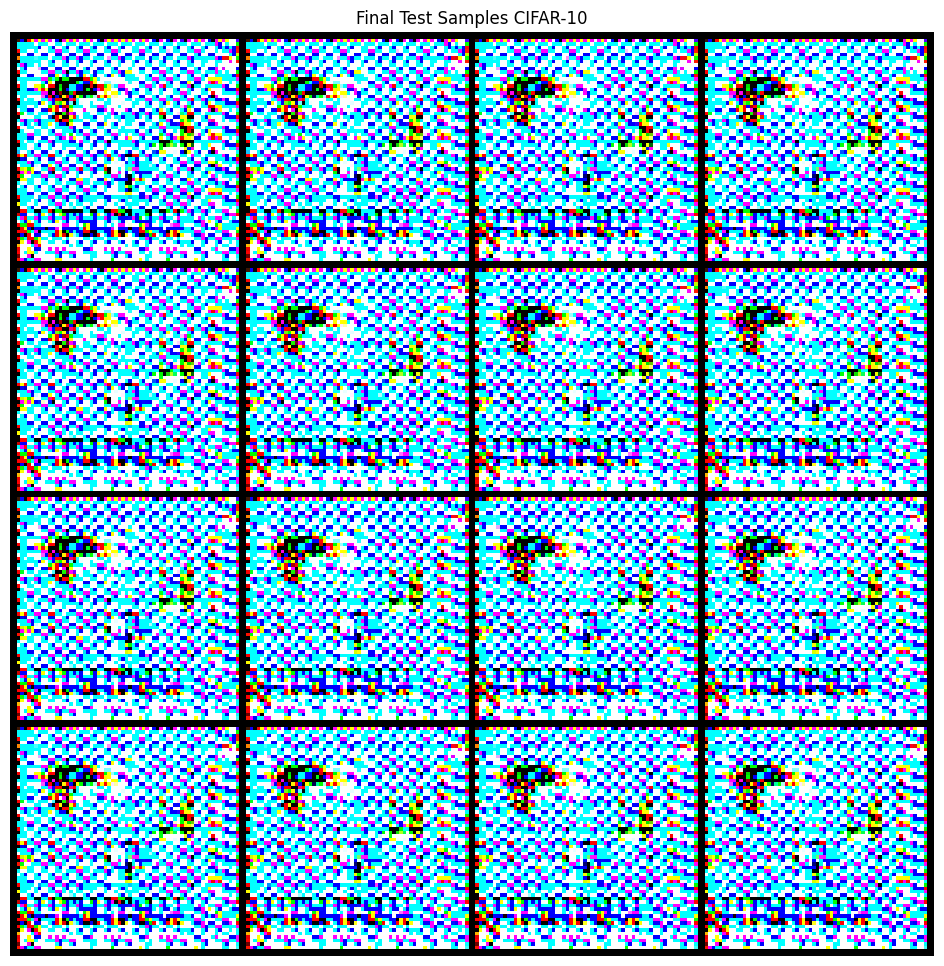

In [126]:
def plot_curves(logs):
    plt.subplots(figsize=(15,14), ncols=1, nrows=2)
    plt.subplot(2,1,1)
    plt.plot(logs["g_loss_hist"], label='G loss')
    plt.plot(logs["d_loss_hist"], label='D loss')    
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(logs["prob_fake_hist"], label='Fake scores D(G(z)) from training D')
    plt.plot(logs["prob_real_hist"], label='Real scores D(x) from training D')
    plt.legend()
    plt.savefig(f'{sample_dir}/part_b_losses_and_scores_cifar10.png', bbox_inches='tight')
    plt.show()
    
plot_curves(logs_cifar)
samples = sample(16, G, z_size, condition=True, flatten=False, device="cuda",
                 gen_one_hot=gen_one_hot)
plt.figure(figsize=(12,12))
plt.title("Final Test Samples CIFAR-10")
plt.imshow(make_image_grid((samples + 1)/2, nrow=4))
plt.axis("off")
plt.savefig(f'{sample_dir}/part_b_cifar10_test_samples.png', bbox_inches='tight')
plt.show()

### Questions to consider

- A stanard diffulty of GAN training is tuning the balance between Generator and Discriminator. How would you balance the training between G and D? What choice influence this balance?

- Can you think of more loss terms to add here in the final objective? What effect do these aim to achieve? 

- How does the sample quality develop during training? Does it always keep improving? Why is this the case? 